In [136]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pymc3 as pm
import pandas as pd

%matplotlib inline

RANDOM_SEED =58

In [377]:
MyPrData = {'density':[7.17, 7.08,7.06,7.13,7.17,7.18], 'bulk_density':[7.86,7.86, 7.86, 7.86, 7.852, 7.852], 'E':[133.7,133.6,145.6,147.3,165.1,166.7], 'material':['FeCu','FeCu' ,'DistSA','DistSA', 'ACrM*','ACrM*']}
dfMyData = pd.DataFrame.from_dict(MyPrData)
dfMyData['P']=1-dfMyData.density/dfMyData.bulk_density
dfMyData['Er'] =dfMyData.E/210
dfMyData1 = dfMyData[['P','Er','material']]

In [139]:
#raw_density =np.array([6.60, 6.73, 6.74,6.75,6.84, 6.89, 6.90, 6.88, 7.01,7.03]).reshape(-1,1)
#E_modulus =np.array([135.502, 136.828,136.644,137.792,148.436,147.230,147.278,147.120,147.677,158.005]).reshape(-1,1)

dfDA = df.iloc[20:,[4,5,6]]
#rel_modulus = df.loc[df.mat_code ==0 , 'Er']
#mat_code=df.mat_code.values
dfDA

,porosity,Er,material
20,0.087,0.778774,ACrM
21,0.085,0.786321,ACrM


In [140]:
# Test data
Xtrain=dfFe.porosity.values # Relative porosity
Ytrain=dfFe.Er.values
n=len(Xtrain)
n

18

In [141]:
Xdata = np.column_stack((Xtrain, Xtrain**2)) #Regressors matrix
Xdata.shape

(18, 2)

In [196]:
with pm.Model() as model:
          
    #Priors
    #E0 =pm.Normal('E0', mu=212, sd=10)
    b = pm.Normal('b', mu=1.6, sd=1, shape =1)
    sigma = pm.HalfNormal('sigma', sd=0.2)
    pm.Deterministic('Pc',1/b)
    beta = [-b-1, b]
    
    Xshared=pm.Data('porosity', Xdata)

    #link function
    mu = 1 +pm.math.dot(Xshared, beta)

    #likelihood
    y = pm.Normal('y', mu =mu, sd= sigma, observed = Ytrain)
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)
    

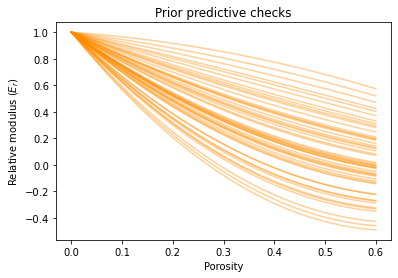

In [201]:
_, ax = plt.subplots()

x = np.linspace(0, 0.6, 50)

for  b in prior_checks["b"]:
    y = (1- x)*(1-b*x)
    ax.plot(x, y, c="#FF8C00", alpha=0.4)

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Prior predictive checks");
#plt.savefig('prior_predictive.png', dpi=300)

In [190]:
Pc_apparent_density = 1-3/7.86
b_apparent_density = 1/Pc_apparent_density
[Pc_apparent_density, b_apparent_density]

[0.6183206106870229, 1.6172839506172838]

In [198]:
with model:
    trace=pm.sample(2000, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 256 seconds.


In [199]:
import arviz as az


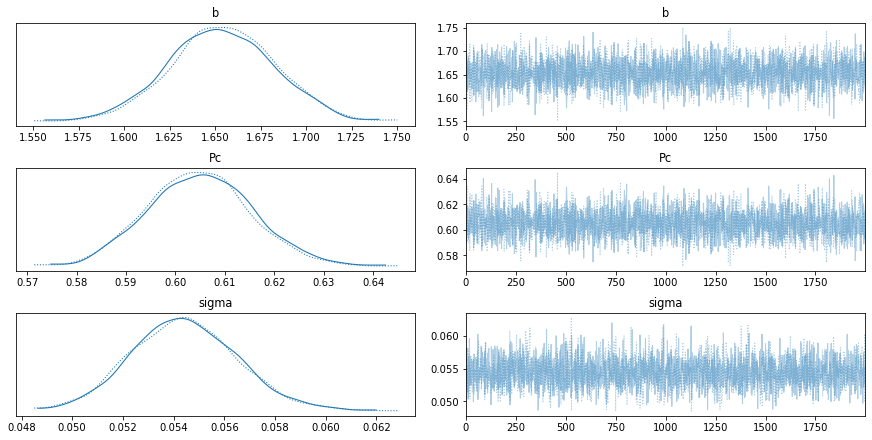

In [308]:
az.plot_trace(trace, var_names=['b', 'Pc','sigma']);
plt.savefig('posterior.png', dpi=300)

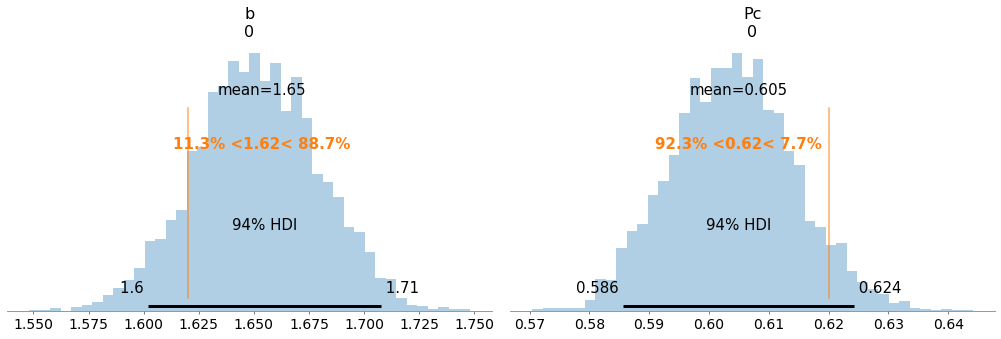

In [317]:
az.plot_posterior(trace, var_names=['b', 'Pc'], ref_val=[1.62,0.62],
    kind='hist', round_to=3);
#plt.savefig('posterior_hist.png', dpi=300)

In [322]:
az.summary(trace, var_names=['b', 'Pc', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
b[0],1.654,0.028,1.602,1.707
Pc[0],0.605,0.010,0.586,0.624
sigma,0.054,0.002,0.050,0.058


In [324]:
#Posterior predictive
Xtest =np.linspace(0, 0.6 ,50)

with model:
    pm.set_data({'porosity': np.column_stack((Xtest, Xtest**2)) })
    y_ppc = pm.sample_posterior_predictive(trace, var_names=["b", "y"], random_seed=RANDOM_SEED )

In [325]:
mu_pp = ((1- y_ppc["b"]*Xtest)*(1-Xtest))
y_ppc['y'].shape

(4000, 50, 18)

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


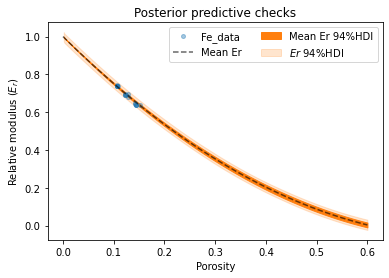

In [337]:
_, ax = plt.subplots() #figsize=(8,6)
ax.plot(Xtrain, Ytrain, ".", ms=8, alpha=0.4, label="Fe_data")
#ax.plot(dfDA.porosity, dfDA.Er, "o", ms=8, alpha=0.4, label="ACrM_data")
#ax.plot(Xtrain, Ytrain, "o", ms=4, alpha=0.4, label="Fe_data")
ax.plot(Xtest, mu_pp.mean(0), 'k--', label="Mean Er", alpha=0.6)
az.plot_hdi(
    Xtest,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 1, "label": "Mean Er 94%HDI"},
)
az.plot_hdi(
    Xtest,
    y_ppc["y"].mean(2),
    ax=ax,
    fill_kwargs={"alpha": 0.2, "label": "$Er$ 94%HDI"},
)  #"color": "#a1dab4",

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);
#plt.ylim([0.6,0.85])
#plt.xlim([0.08,0.16])
#plt.savefig('ppc.png', dpi=300)

In [ ]:
# Model check with data from other research papers

In [351]:
dfCr = (pd.read_csv('./DataAzadbeh.csv'))
#dfCr['mat_code'] = dfCr['material'].map({'ACrL': 0 , 'ACrM':1})
dfCr['Er']=dfCr.E_Gpa/210

In [352]:
AMo = {'P': [0.11, 0.10, 0.09, 0.08, 0.1], 'Er': [0.56, 0.58, 0.63, 0.58, 0.59], 'material':['AstMo','AstMo','AstMo','AstMo','AstMo']}
dfAMo = pd.DataFrame.from_dict(AMo)

In [380]:
dfComp =dfCr[['P', 'Er', 'material']]
dfComp =dfComp.append(dfAMo, ignore_index=True)
dfComp=dfComp.append(dfMyData1, ignore_index=True)


In [345]:
import seaborn as sns

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


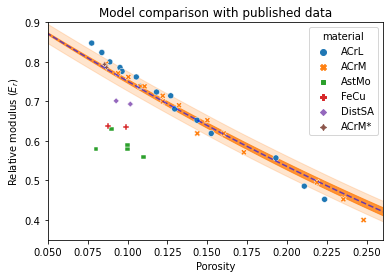

In [384]:
_, ax = plt.subplots()  #figsize=(12,8)

#ax.plot(Xtrain, Ytrain, "o", ms=8, alpha=0.4, label="Fe_data")
#ax.plot(dfDA.porosity, dfDA.Er, "o", ms=8, alpha=0.4, label="ACrM_data")
#ax.plot(Xtrain, Ytrain, "o", ms=4, alpha=0.4, label="Fe_data")
#ax.plot(Xtest, (y_ppc['y'][::10].mean(2)).T, '.c', alpha=0.1)
ax.plot(Xtest, mu_pp.mean(0), 'b--',  alpha=0.6)
az.plot_hdi(
    Xtest,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8},
)
az.plot_hdi(
    Xtest,
    y_ppc["y"].mean(2),
    ax=ax,
    fill_kwargs={"alpha": 0.2},
)

ax.set_xlabel("Porosity")
ax.set_ylabel("Relative modulus ($E_r$)")
ax.set_title("Model comparison with published data")
#ax.legend(ncol=2, fontsize=10);
plt.ylim([0.35,0.9])
plt.xlim([0.05,0.26])
sns.scatterplot(x=dfComp['P'], y=dfComp['Er'], hue=dfComp['material'], marker='8', style=dfComp['material'])
#sns.scatterplot(x=dfAMo['P'], y=dfAMo['Er'], hue=dfAMo['material'], marker='8')
plt.savefig('model_comp.png', dpi=300)

In [212]:
sns.histplot(data=((y_ppc['y'][::18])*212)

SyntaxError: unexpected EOF while parsing (<ipython-input-212-8f33b549a7f7>, line 1)

In [216]:
((y_ppc['y'][::10]).mean(2)*212).T.shape

(50, 400)

abc

In [229]:
#Posterior predictive P=0.1
Xtest01 = 0.1

with model:
    pm.set_data({'porosity': np.column_stack((Xtest01, Xtest01**2)) })
    y_ppc1 = pm.sample_posterior_predictive(trace, var_names=["b", "y"], random_seed=RANDOM_SEED )

<AxesSubplot:>

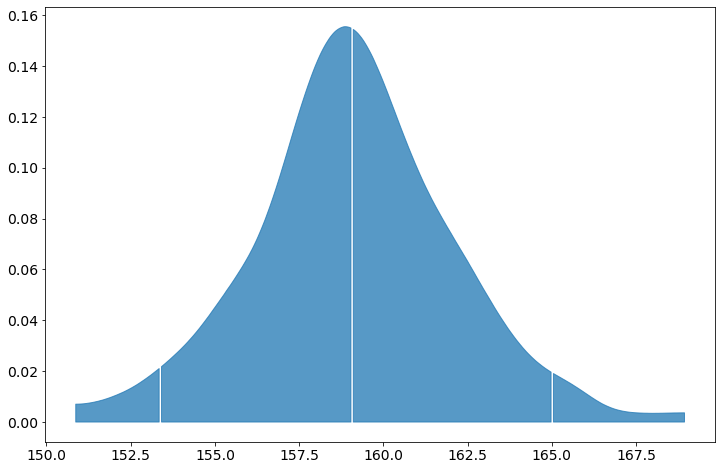

In [236]:
_, ax = plt.subplots(figsize=(12,8))

#ax.plot(Xtrain, Ytrain, "o", ms=8, alpha=0.4, label="Fe_data")
#ax.plot(dfDA.porosity, dfDA.Er, "o", ms=8, alpha=0.4, label="ACrM_data")
#ax.plot(Xtrain, Ytrain, "o", ms=4, alpha=0.4, label="Fe_data")
az.plot_kde( (y_ppc1['y'][::10].mean(2)).T*212, quantiles=[0.03, 0.5, 0.97])
#ax.plot(Xtest, mu_pp.mean(0), 'b--', label="Mean Er", alpha=0.6)
#az.plot_hdi(
#    Xtest,
#    mu_pp,
#    ax=ax,
#    fill_kwargs={"alpha": 0.8, "label": "Mean Er 94% HPD"},)


In [253]:
np.quantile(y_ppc1['y'][::10].mean(2), 0.97)

0.777519188714219

In [158]:
import seaborn as sns

<AxesSubplot:xlabel='porosity', ylabel='Er'>

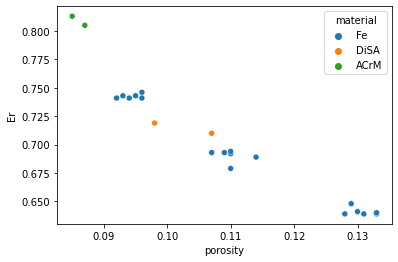

In [159]:
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])

In [284]:
mu_=(1-1/(1-2.89/7.84)*Xtest)*(1-Xtest)
mu_l =mu_-0.03
mu_u =mu_+0.03
mu_.shape

(50,)

<AxesSubplot:xlabel='Porosity', ylabel='Relative E modulus (Er)'>

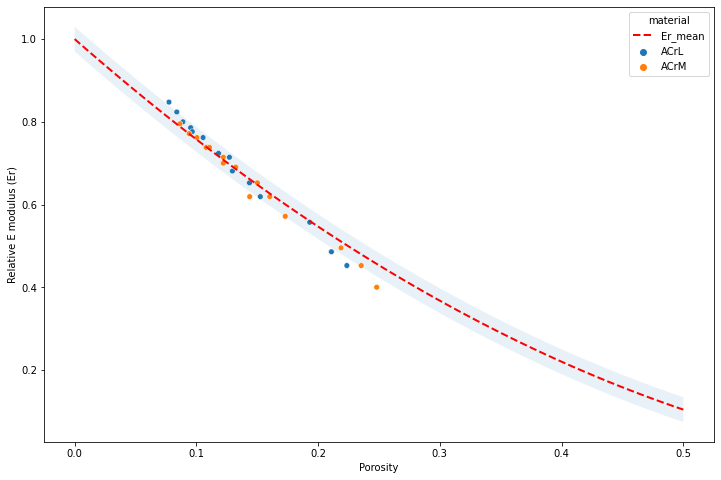

In [293]:
_, ax = plt.subplots(figsize=(12,8))

ax.plot(Xtest, mu_, 'r--', lw=2, label='Er_mean')
ax.fill_between(Xtest, mu_l , mu_u,  alpha=0.1)
#plt.scatter(Xtrain_p,Ytrain, label='Er_data')
#plt.plot(Xtest, yd.mean(axis=1), 'r--',lw=2, label="Er_ppc_mean", alpha=0.6)
plt.legend()
plt.xlabel('Porosity')
plt.ylabel('Relative E modulus (Er)')
sns.scatterplot(x=dfCr['P'], y=dfCr['Er'], hue=dfCr['material'], marker='8')
#plt.xlim([0, 0.2])
#plt.ylim([0.5,1])